# Demonstration notebook `deepSI`

## 1.1 Creating/obtaining train, val and test data in the form `Input_Output_data`

In [1]:
import deepSI as dsi
import numpy as np

## Generate dataset ## 
np.random.seed(0)
ulist = np.random.randn(10_000) #input sequence
x = [0, 0] #initial state
ylist = [] #output sequence
for uk in ulist:
    ylist.append(x[1]*x[0]*0.1 + x[0] + np.random.randn()*1e-3)  #compute output
    x = x[0]/(1.2+x[1]**2) + x[1]*0.4, \
        x[1]/(1.2+x[0]**2) + x[0]*0.4 + uk*(1+x[0]**2/10) #advance state

# Put the inputs and outputs in a Input_output_data format
data = dsi.Input_output_data(u=ulist, y=np.array(ylist)) 

# Split dataset
train, val, test  = data[:8000], data[8000:9000], data[9000:]

print(f'{train = }')
print(f'{val = }')
print(f'{test = }')

### load dataset ###
from nonlinear_benchmarks import Cascaded_Tanks
train_val, test = Cascaded_Tanks()
train, val = train_val[:850], train_val[850:]
print(f'{train_val = }')
print(f'{test = }')

train = Input_output_data u.shape=(8000,) y.shape=(8000,) sampling_time=Discrete time
val = Input_output_data u.shape=(1000,) y.shape=(1000,) sampling_time=Discrete time
test = Input_output_data u.shape=(1000,) y.shape=(1000,) sampling_time=Discrete time
train_val = Input_output_data "train Cascaded_Tanks" u.shape=(1024,) y.shape=(1024,) sampling_time=4.0
test = Input_output_data "test Cascaded_Tanks" u.shape=(1024,) y.shape=(1024,) sampling_time=4.0 state_initialization_window_length=5


In [2]:
# Testing: you can ignore this if you are just learning deepSI and not testing the module.
import hashlib, torch
hash_array = lambda ar: hashlib.sha256((ar.detach().numpy() if isinstance(ar,torch.Tensor) else ar).data.tobytes()).hexdigest()[:8]
assert hash_array(train.u)=='d2963ee6' and hash_array(test.y)=='fb132046'

## 1.2 Creating a SUBNET structure 

Creating a model starts by characterizing by which kind of data it will be applied on. Example: number of inputs (`nu=3` for 3 inputs) or scalar inputs `nu='scalar'`. Futhermore, the range of the outputs and inputs need to be characterized as to apply normalize and de-normalize the of `f`, `h` and `encoder`.

If you want to use zero-mean, std one normalization (z-score) you can use `get_nu_ny_and_auto_norm` to characterize what kind of data you are working with.

This can be used to initilize the SUBNET method (https://arxiv.org/abs/2012.07697, https://www.sciencedirect.com/science/article/pii/S0005109823003710) given by three realtionships; 
$$
x_{k+1} = f_\theta(x_k, u_k)
$$
$$
\hat{y}_k = h_\theta(x_k)
$$
$$
x_0 = \psi_\theta(u_\text{past}, y_\text{past})
$$
where $\psi$ is the encoder that initializes the state. It is also possible to make $h_\theta(x_k, u_k)$ by setting `feedthrough=True`.


In [3]:
import deepSI as dsi
import torch

nx, nb, na = 2, 5, 5
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train_val) 
# Equivilent to 
# nu = 'scalar', ny = 'scalar', norm = dsi.Norm(umean=train.u.mean(0), ustd=train.u.std(0), ymean=train.y.mean(0), ystd=train.y.std(0))
torch.manual_seed(1)
model = dsi.SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na)
# this model has three components:
# print(model.f)
# print(model.h)
# print(model.encoder)

x = torch.randn(1,model.nx) # 1 batch size and nx state vector size 
u = torch.randn(1) #1 batch size and 'scalar' input size
print(f'{model.f(x, u) = }') #the components can be evaluated in desired point


model.f(x, u) = tensor([[ 0.4626, -1.0500]], grad_fn=<AddBackward0>)


In [4]:
assert str(model.f(x, u))=='tensor([[ 0.4626, -1.0500]], grad_fn=<AddBackward0>)'

## 1.3 Fitting is a function in deepSI

Fitting can be done with the following function:

```python
def fit(model: nn.Module, train:Input_output_data, val:Input_output_data, n_its:int, T:int=50, \
        batch_size:int=256, stride:int=1, val_freq:int=250, optimizer:optim.Optimizer=None, \
            device=None, compile_mode=None, loss_fun=compute_NMSE, val_fun=compute_NMSE):
```

where `T` is the trunctation lenght of the subsequences, `val_freq` is the frequency of which the validation loop will run.

You can also use `deepSI.fitting.fit_minimal_implementation` which is a much smaller function but is missing some features. This can be handy since this one does not implement learning rate schedulers.

In [5]:
train_dict = dsi.fit(model, train=train, val=val, n_its=1_000, T=30, batch_size=64, val_freq=100)

Number of samples to train on = 816


  0%|          | 0/1000 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 1.28713!! nan samps/sec
it     100 NRMS loss 0.59047 NRMS val 0.81747!! 3050.50 samps/sec
it     200 NRMS loss 0.33494 NRMS val 0.55732!! 3237.22 samps/sec
it     300 NRMS loss 0.21476 NRMS val 0.68364   3311.18 samps/sec
it     400 NRMS loss 0.19359 NRMS val 0.50856!! 3305.96 samps/sec
it     500 NRMS loss 0.17288 NRMS val 0.46514!! 3317.73 samps/sec
it     600 NRMS loss 0.16436 NRMS val 0.41950!! 3309.43 samps/sec
it     700 NRMS loss 0.15927 NRMS val 0.40306!! 3302.78 samps/sec
it     800 NRMS loss 0.14528 NRMS val 0.38296!! 3306.76 samps/sec
it     900 NRMS loss 0.14278 NRMS val 0.34408!! 3305.80 samps/sec
it   1,000 NRMS loss 0.14716 NRMS val 0.37088   3309.38 samps/sec


Here `train_dict` contains information about the training. More information will be given on this later.

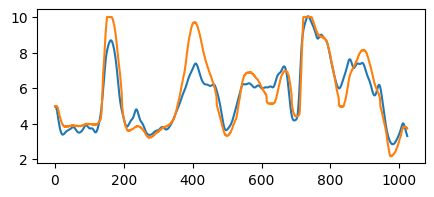

NRMS=38.17%
RMSE=0.8031 V


In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,2))
test_sim = model.simulate(test)
plt.plot(test_sim.y) #simulate is apply_experiment equivilent
plt.plot(test.y)
plt.show()
from nonlinear_benchmarks.error_metrics import NRMSE, RMSE
print(f'NRMS={NRMSE(test.y[model.na:], test_sim.y[model.na:]):.2%}')
print(f'RMSE={RMSE(test.y[model.na:], test_sim.y[model.na:]):.4f} V')


In [7]:
assert RMSE(test.y[model.na:], test_sim.y[model.na:]) < 1.0
assert hash_array(test_sim.u)+hash_array(test_sim.y) == '3fc2c421f38edda7'

### 1.4 Continous time SUBNET

`deepSI` also contains options for continuous-time esitmation. For example: https://arxiv.org/abs/2204.09405 is implemented in `models.SUBNET_CT` given by the following structure.

$$
\dot{x}(t) = f_\theta^{\text{CT}}(x(t), u(t))
$$
$$
\hat{y}(t) = h_\theta(x(t))
$$
$$
x(0) = \psi_\theta(u_\text{past}, y_\text{past})
$$
where $\psi$ is the encoder that initializes the state.


In [8]:
import deepSI as dsi
import torch
from nonlinear_benchmarks import Cascaded_Tanks
from deepSI.networks import euler_integrator, rk4_integrator, rk45_integrator
train, test = Cascaded_Tanks()

nx, nb, na = 2, 5, 5
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train)
torch.manual_seed(0)
model_CT = dsi.SUBNET_CT(nu, ny, norm, nx=2, na=4, nb=4, integrator=euler_integrator)
train_dict = dsi.fit(model_CT, train[:900], test[900:], n_its=1000, T=30, val_freq=50)

Number of samples to train on = 867


  0%|          | 0/1000 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 1.00484!! nan samps/sec
it      50 NRMS loss 0.43281 NRMS val 0.43648!! 9110.40 samps/sec
it     100 NRMS loss 0.25465 NRMS val 0.17438!! 9343.13 samps/sec
it     150 NRMS loss 0.21626 NRMS val 0.26487   9026.71 samps/sec
it     200 NRMS loss 0.18967 NRMS val 0.24029   9202.77 samps/sec
it     250 NRMS loss 0.16368 NRMS val 0.16510!! 9211.84 samps/sec
it     300 NRMS loss 0.14797 NRMS val 0.11882!! 9299.40 samps/sec
it     350 NRMS loss 0.13688 NRMS val 0.16736   9341.99 samps/sec
it     400 NRMS loss 0.12764 NRMS val 0.25270   9384.95 samps/sec
it     450 NRMS loss 0.11961 NRMS val 0.31058   9396.72 samps/sec
it     500 NRMS loss 0.11332 NRMS val 0.38390   9439.81 samps/sec
it     550 NRMS loss 0.10589 NRMS val 0.42049   9467.18 samps/sec
it     600 NRMS loss 0.10072 NRMS val 0.43204   9425.18 samps/sec
it     650 NRMS loss 0.09725 NRMS val 0.43822   9447.53 samps/sec
it     700 NRMS loss 0.09236 NRMS val 0.41764   9460.37 samps/sec
it     750 NRMS lo

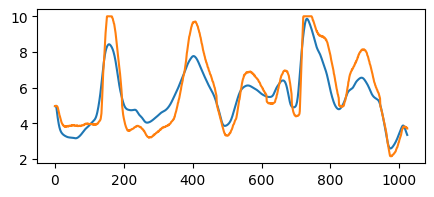

NRMS=43.98%
RMSE=0.9248 V


In [9]:
from matplotlib import pyplot as plt
test_sim_CT = model_CT.simulate(test)
plt.figure(figsize=(5,2))
plt.plot(test_sim_CT.y) #simulate is apply_experiment equivilent
plt.plot(test.y)
plt.show()
from nonlinear_benchmarks.error_metrics import NRMSE, RMSE
print(f'NRMS={NRMSE(test.y[model_CT.na:], test_sim_CT.y[model_CT.na:]):.2%}')
print(f'RMSE={RMSE(test.y[model_CT.na:], test_sim_CT.y[model_CT.na:]):.4f} V')

In [10]:
assert RMSE(test.y[model.na:], test_sim_CT.y[model.na:]) < 1.0
assert hash_array(test_sim_CT.u)+hash_array(test_sim_CT.y) == '3fc2c4216721bc73'

### Changing the intergator

You can change out the integrator as desired as

In [11]:
from deepSI.networks import euler_integrator, rk4_integrator, rk45_integrator
from nonlinear_benchmarks.error_metrics import RMSE

#this is a 3 step rk4_integrator
integrator = rk4_integrator
n_steps = 3
model_CT.integrator = lambda f,x,u,dt: integrator(f,x,u,dt, n_steps) 
print(f'RMSE={RMSE(test.y, model_CT.simulate(test).y):.4f} V')

RMSE=0.9292 V


## 2.1 Cutomizable SUBNET

If you want to parameterize differently (number of layers and different functions) than you can pass your desired `f`, `h` and `encoder` ($\psi_\theta$) into the SUBNET structure class.  

Keep in mind that these function need to have the following function characteristics where $b$ is the batch dimension.

$$f_\theta : \mathbb{R}^{b \times n_x} \times \mathbb{R}^{b \times n_u} \rightarrow \mathbb{R}^{b \times n_x}$$

$$h_\theta : \mathbb{R}^{b \times n_x} \times \mathbb{R}^{b \times n_u} \rightarrow \mathbb{R}^{b \times n_y} \text{\ if feedthrough=True else }h_\theta : \mathbb{R}^{b \times n_x} \rightarrow \mathbb{R}^{b \times n_y}$$

$$\psi_\theta : \mathbb{R}^{b \times n_b \times n_u} \times \mathbb{R}^{b \times n_a \times n_y} \rightarrow \mathbb{R}^{b \times n_x}$$

Or in the case that the input and output are scalars (`nu = 'scalar'` and `ny = 'scalar'`)

$$f_\theta : \mathbb{R}^{b \times n_x} \times \mathbb{R}^{b} \rightarrow \mathbb{R}^{b \times n_x}$$

$$h_\theta : \mathbb{R}^{b \times n_x} \times \mathbb{R}^{b} \rightarrow \mathbb{R}^{b} \text{\ if feedthrough=True else }h_\theta : \mathbb{R}^{b \times n_x} \rightarrow \mathbb{R}^{b}$$

$$\psi_\theta : \mathbb{R}^{b \times n_b} \times \mathbb{R}^{b \times n_a} \rightarrow \mathbb{R}^{b \times n_x}$$

If a simple multi layer perceptron or feed forward neural network (with linear residual layer) is desired you can use `MLP_res_net`.


In [12]:
from deepSI.networks import MLP_res_net
from torch import nn
from deepSI.models import SUBNET
from deepSI import get_nu_ny_and_auto_norm
from nonlinear_benchmarks import Cascaded_Tanks
train, test = Cascaded_Tanks()
nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)
feedthrough = False

f =       norm.f(       MLP_res_net(input_size = [nx , nu],                       output_size = nx, activation=nn.Sigmoid))
h =       norm.h(       MLP_res_net(input_size = [nx, nu] if feedthrough else nx, output_size = ny, n_hidden_layers=5, n_hidden_nodes=10))
encoder = norm.encoder( MLP_res_net(input_size = [(nb,nu) , (na,ny)],             output_size = nx, n_hidden_layers=1, n_hidden_nodes=15))

print(f) #has f(x,u) -> x with batch
print(h) #has h(x,u) -> y with batch if feedthrough = True else h(x) -> y
print(encoder) #has encoder(upast, ypast) -> x

print(SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na, f=f, h=h, encoder=encoder))

IO_normalization_f(
  (fun): MLP_res_net(
    (net_res): Linear(in_features=3, out_features=2, bias=True)
    (net_nonlin): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)
IO_normalization_h(
  (fun): MLP_res_net(
    (net_res): Linear(in_features=2, out_features=1, bias=True)
    (net_nonlin): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Tanh()
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=10, bias=True)
      (7): Tanh()
      (8): Linear(in_features=10, out_features=10, bias=True)
      (9): Tanh()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)
IO_normalization_

## 2.2 Available models

You can construct your own networks but also `deepSI` provides multiple useful ones.

 * SUBNET encoder structue (`deepSI.models.SUBNET`)
    * see: https://arxiv.org/abs/2012.07697 or https://www.sciencedirect.com/science/article/pii/S0005109823003710
  * Continuous time SUBNET encoder structure (`deepSI.models.SUBNET_CT`)
    * see: https://arxiv.org/abs/2204.09405 
  * Base class for fully custom SUBNET structures with shared parameters between `f`, `h` or `encoder`. (`deepSI.models.Custom_SUBNET`)
  * CNN SUBNET (`CNN_SUBNET`)
    * see chapter 4: https://research.tue.nl/files/318935789/20240321_Beintema_hf.pdf
  * LPV SUBNET (`SUBNET_LPV` and `SUBNET_LPV_ext_scheduled`)
    * see: https://arxiv.org/abs/2204.04060
  * port HNN SUBNET (`pHNN_SUBNET`)
    * see: https://arxiv.org/abs/2305.01338

## 3.1 Creating you own SUBNET structure

A limitation in the `SUBNET` class is that the `f`, `h` and the `encoder` cannot share any parameters. If this is not the case than you can still create you own cutom SUBNET structure.

This is done by inhereting `Custom_SUBNET` and defining a forward method with the characteristic:
* `forward(upast, ypast, ufuture) = yfuture_sim`
  * `upast.shape = (batch_dim, nb, nu)`,
  * `ypast.shape = (batch_dim, na, ny)`,
  * `ufuture.shape = (batch_dim, T, nu)`,
  * `yfuture_sim.shape = (batch_dim, T, ny)`

(and removing `nu` and `ny` from these shapes if they are `'scalar'`)

Below you can find an example for a LPV structure, see: https://arxiv.org/abs/2204.04060

This structure does not accept `nu='scalar'` or `ny = 'scalar'` and thus 


In [13]:
from deepSI.models import Custom_SUBNET, validate_custom_SUBNET_structure
from deepSI import Norm, get_nu_ny_and_auto_norm
from deepSI.networks import Bilinear, MLP_res_net
import torch
import numpy as np
class SUBNET_LPV(Custom_SUBNET):
    def __init__(self, nu, ny, norm:Norm, nx, n_schedual, na, nb, scheduling_net=None, A=None, B=None, C=None, D=None, encoder=None, feedthrough=True):
        if np.any((2*abs(norm.ymean)>norm.ystd).numpy()) or np.any((2*abs(norm.umean)>norm.ustd).numpy()):
            from warnings import warn
            warn('SUBNET_LPV assumes that the data is approximatly zero mean. Not doing so can lead to unintended behaviour.')
        assert isinstance(nu, int) and isinstance(ny, int) and isinstance(n_schedual, int) and feedthrough, 'SUBNET_LPV requires the input, output schedualing parameter to be vectors and feedthrough to be present'
        super().__init__()
        self.nu, self.ny, self.norm, self.nx, self.n_schedual, self.na, self.nb, self.feedthrough = nu, ny, norm, nx, n_schedual, na, nb, feedthrough
        self.A = A if A is not None else Bilinear(n_in=nx, n_out=nx, n_schedual=n_schedual)
        self.B = B if B is not None else Bilinear(n_in=nu, n_out=nx, n_schedual=n_schedual, std_input=norm.ustd)
        self.C = C if C is not None else Bilinear(n_in=nx, n_out=ny, n_schedual=n_schedual, std_output=norm.ystd)
        self.D = D if D is not None else Bilinear(n_in=nu, n_out=ny, n_schedual=n_schedual, std_output=norm.ystd, std_input=norm.ustd)
        self.encoder = encoder if encoder is not None else norm.encoder(MLP_res_net(input_size = [(nb,nu) , (na,ny)], output_size = nx))
        self.scheduling_net = scheduling_net if scheduling_net is not None else norm.f(MLP_res_net(input_size = [nx , nu], output_size = n_schedual))
        validate_custom_SUBNET_structure(self) #does checks if forward is working as intended
    
    def forward(self, upast: torch.Tensor, ypast: torch.Tensor, ufuture: torch.Tensor, yfuture: torch.Tensor=None):
        bmv = lambda A, x: torch.bmm(A, x[:, :, None])[:,:,0] #batched matrix vector multiply
        yfuture_sim = []
        x = self.encoder(upast, ypast)
        for u in ufuture.swapaxes(0,1): #iterate over time
            p = self.scheduling_net(x, u)
            A, B, C, D = self.A(p), self.B(p), self.C(p), self.D(p)
            y = bmv(C, x) + bmv(D, u)
            x = bmv(A, x) + bmv(B, u)
            yfuture_sim.append(y)
        return torch.stack(yfuture_sim, dim=1)

from nonlinear_benchmarks import Silverbox
train, test = Silverbox(atleast_2d=True)
nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)

SUBNET_LPV(nu, ny, norm, nx, n_schedual=2, na=na, nb=nb)

SUBNET_LPV(
  (A): Bilinear()
  (B): Bilinear()
  (C): Bilinear()
  (D): Bilinear()
  (encoder): IO_normalization_encoder(
    (fun): MLP_res_net(
      (net_res): Linear(in_features=10, out_features=2, bias=True)
      (net_nonlin): Sequential(
        (0): Linear(in_features=10, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): Tanh()
        (4): Linear(in_features=64, out_features=2, bias=True)
      )
    )
  )
  (scheduling_net): IO_normalization_f(
    (fun): MLP_res_net(
      (net_res): Linear(in_features=3, out_features=2, bias=True)
      (net_nonlin): Sequential(
        (0): Linear(in_features=3, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): Tanh()
        (4): Linear(in_features=64, out_features=2, bias=True)
      )
    )
  )
)

If needed you can use network provided in `deepSI.networks` to formulate your method. For example it contains:

 * `MLP_res_net` A Multi-Layer Perceptron with Residual Connection (MLP_res_net)
 * `euler_integrator`, `rk4_integrator`, `rk45_integrator` integrators.
 * `Bilinear` where `A(p) = A_0 + A_1 p_1 + A_2 p_2 + ... + A_n_schedual p_n_schedual`
 * `CNN_vec_to_image` and `CNN_encoder` to go from a vector to an image and from an image to a vector.
 * `ELU_lower_bound` lower bounds a function as `torch.nn.functional.elu(y - b) + b`
 * `Matrix_converter` converts a vector into a matrix.
 * `Skew_sym_converter`, `Sym_pos_semidef_converter`. Converts a matrix to a skew symetric matrix and semidefiniate positive matrix respectively. 
 * `Ham_converter` converts a scalar output to haminonian by scaling the output.
 * `Bias_net` where `f(x)=b` where `b` is a bias (trainable)
 * `Contant_net` where `f(x)=c` where `c` is a constant (untrainable)
 * `Sum_net` conbine multiple networks `f_1(x) + f_2(x) + f_3(x) + ... + f_n(x)`
 * `Quadratic_net` where `x^T Q X`

This is only a small sampling of function that you might require for you work so feel free to create new ones. They just need to be a `torch.nn.Module` and they will work in `deepSI`.

## 4. Normalization

Often to get the result you need to carfully consider the normalization of your data. I recommend two different strategies for this:


### 4.1 Normalization strategy 1: Pre-processing data

You can pre-process you data which is quite a simple approach:

In [14]:
import deepSI as dsi
import nonlinear_benchmarks as nlb

#explicit: way:
train_val_0, test_0 = nlb.WienerHammerBenchMark()
umean, ustd, ymean, ystd = train_val_0.u.mean(), train_val_0.u.std(), train_val_0.y.mean(), train_val_0.y.std()
train_val = dsi.Input_output_data(u=(train_val_0.u - umean)/ustd, y=(train_val_0.y - ymean)/ystd)
test = dsi.Input_output_data(u=(test_0.u - umean)/ustd, y=(test_0.y - ymean)/test_0.y.std())
model = dsi.SUBNET(nu='scalar', ny='scalar', norm=dsi.Norm(0,1,0,1)) #the data is normalized so the model can have a identity norm.

#using deepSI functions.
train_val_0, test_0 = nlb.WienerHammerBenchMark()
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train_val_0)
train_val, test = norm.transform(train_val_0), norm.transform(test_0)
model = dsi.SUBNET(nu='scalar', ny='scalar', norm=dsi.Norm(0,1,0,1)) #the data is normalized so the model can have a identity norm.

### 4.2 Normalization strategy 2: Online

You can change the functions `f`, `h` and `encoder` such that they normalize and unnormalize the data themselfs. For examples you can write:

`f_actual(x,u) = f_norm(x, (u-umean)/ustd)`

`h_actual(x, u) = ymean + ystd*h_norm(x, (u-umean)/ustd)`

`encoder_actual(upast, ypast) -> encoder_norm((upast - umean)/ustd, (ypast - ymean)/ystd)`

where `f_norm`, `h_norm`, `encoder_norm` are the functions in the normalized space. You can automaticly wrap any normalized function by using `norm.f`, `norm.h` and `norm.encoder` as follows:

If `f`, `h`, or the `encoder` is not given in `SUBNET` this strategy is also applied with the given `norm`

Also note that for Continuous time you can use `norm.f_CT` to also add a time/derivative normalization factor, see: https://arxiv.org/abs/2204.09405


In [15]:
import deepSI as dsi
import nonlinear_benchmarks as nlb
from torch import nn

train, test = nlb.WienerHammerBenchMark()
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train)
feedthrough = False
nx, na, nb = 6, 20, 20

f =       norm.f(       dsi.networks.MLP_res_net(input_size = [nx , nu],                       output_size = nx, activation=nn.Sigmoid))
h =       norm.h(       dsi.networks.MLP_res_net(input_size = [nx, nu] if feedthrough else nx, output_size = ny, n_hidden_layers=5, n_hidden_nodes=10))
encoder = norm.encoder( dsi.networks.MLP_res_net(input_size = [(nb,nu) , (na,ny)],             output_size = nx, n_hidden_layers=1, n_hidden_nodes=15))

model = dsi.SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na, f=f, h=h, encoder=encoder)

## 5. Exporting functions via `torch.onnx.export`

If you want to use your estimated function you can torch the ONNX framework to transport the functions to other languages like `c`, `MATLAB` and `CasaDI`. Below you can find an example for the MATLAB conversion of `model.f`:

In [16]:
import torch
from torch import nn
class Fun(nn.Module):
    def __init__(self, f, model):
        super().__init__()
        self.f = f
        self.model = model
    def forward(self, *args, **kwargs):
        with torch.no_grad():
            return self.f(*args, **kwargs)

import deepSI as dsi
nx = 3
model = dsi.SUBNET('scalar', 'scalar', dsi.Norm(0,1,0,1), nx=nx)
f = Fun(model.f, model)
x = torch.zeros((1, nx))
u = torch.zeros((1,)) if model.nu == 'scalar' else torch.zeros((1,model.nu))

try: 
    torch.onnx.export(
        f,                  # the model (in this case Fun class wrapping your model)
        (x, u),             # input tensors (in this case x and u)
        "f.onnx",       # file name or file path where the model will be saved
        opset_version=12    # specify the ONNX opset version
    )
except torch.onnx.OnnxExporterError as e:
    print(f'{e}')


Module onnx is not installed!


Than in matlab you can import the function as:
```matlab
params = importONNXFunction('f.onnx', 'fmatlab.m')
x = zeros(1,6)
u = zeros(1)
xnext = fmatlab(x, u, params)
```

keep in mind that this still includes the batch dimension (here 1). Also `importONNXFunction` function is missing a number of operations that are included ONNX, so it might sometimes complain.



## 6. Reproducability

If you set a manual seed with `torch.manual_seed(0)` before creating the networks and the model than the results is always the same. 

In [17]:
import deepSI as dsi
from nonlinear_benchmarks import Silverbox
import numpy as np
import torch

train_val, tests = Silverbox()
test = tests[0]
s = int(0.95*len(train_val))
train, val = train_val[:s], train_val[s:]
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train_val)

for _ in range(2):
    torch.manual_seed(0)
    subnet = dsi.SUBNET(nu, ny, norm, nx=4, nb=20, na=20)
    fit_res_subnet = dsi.fit(subnet, train, val, n_its=100, val_freq=10)


Number of samples to train on = 61739


  0%|          | 0/100 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.99626!! nan samps/sec
it      10 NRMS loss 0.96911 NRMS val 0.91461!! 6994.61 samps/sec
it      20 NRMS loss 0.88075 NRMS val 0.87685!! 6956.33 samps/sec
it      30 NRMS loss 0.84420 NRMS val 0.84332!! 6925.06 samps/sec
it      40 NRMS loss 0.75531 NRMS val 0.58872!! 6914.19 samps/sec
it      50 NRMS loss 0.51822 NRMS val 0.54371!! 6911.41 samps/sec
it      60 NRMS loss 0.45830 NRMS val 0.49202!! 6832.69 samps/sec
it      70 NRMS loss 0.40896 NRMS val 0.41274!! 6842.26 samps/sec
it      80 NRMS loss 0.36910 NRMS val 0.36029!! 6851.76 samps/sec
it      90 NRMS loss 0.32021 NRMS val 0.31022!! 6846.92 samps/sec
it     100 NRMS loss 0.27207 NRMS val 0.26480!! 6855.89 samps/sec
Number of samples to train on = 61739


  0%|          | 0/100 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.99626!! nan samps/sec
it      10 NRMS loss 0.96911 NRMS val 0.91461!! 6416.10 samps/sec
it      20 NRMS loss 0.88075 NRMS val 0.87685!! 6679.66 samps/sec
it      30 NRMS loss 0.84420 NRMS val 0.84332!! 6781.43 samps/sec
it      40 NRMS loss 0.75531 NRMS val 0.58872!! 6838.03 samps/sec
it      50 NRMS loss 0.51822 NRMS val 0.54371!! 6854.07 samps/sec
it      60 NRMS loss 0.45830 NRMS val 0.49202!! 6880.16 samps/sec
it      70 NRMS loss 0.40896 NRMS val 0.41274!! 6883.03 samps/sec
it      80 NRMS loss 0.36910 NRMS val 0.36029!! 6887.50 samps/sec
it      90 NRMS loss 0.32021 NRMS val 0.31022!! 6880.70 samps/sec
it     100 NRMS loss 0.27207 NRMS val 0.26480!! 6883.56 samps/sec


## 7. Regularization and custom cost functions

In `fit` you can give custom cost function like by giving an argument for `loss_fun`.

In [18]:
from deepSI import SUBNET, get_nu_ny_and_auto_norm
from deepSI.fitting import compute_NMSE
import torch
from nonlinear_benchmarks import Cascaded_Tanks
import numpy as np
train, test = Cascaded_Tanks()

nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)
model = SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na)

def ridge_L2_regularization(model, upast, ypast, ufuture, yfuture, kappa=1):
    yfuture_model = model(upast, ypast, ufuture)
    amp = torch.stack([(p**2).sum() for p in model.parameters()])/torch.as_tensor([p.numel() for p in model.parameters()]) #parameter amplitude
    return ((yfuture-yfuture_model)**2/model.norm.ystd**2).mean() + torch.mean(amp)*kappa

from deepSI import fit
kappa = 0.1
my_loss = lambda *args: ridge_L2_regularization(*args, kappa=kappa)
train_dict = fit(model, train, test, n_its=101, T=40, batch_size=64, val_freq=100, loss_fun=my_loss, val_fun=compute_NMSE)

Number of samples to train on = 980


  0%|          | 0/101 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 1.04559!! nan samps/sec
it     100 NRMS loss 0.81684 NRMS val 0.98126!! 2338.65 samps/sec


## 8. Training/fitting details

In [19]:
import deepSI as dsi
import nonlinear_benchmarks as nlb
from matplotlib import pyplot as plt

train_val, test = nlb.Silverbox()
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train_val)
train_val, test = norm.transform(train_val), norm.transform(test)
s = int(len(train_val)*0.95)
train, val = train_val[:s], train_val[s:]
model = dsi.models.SUBNET(nu, ny, dsi.Norm(0, 1, 0, 1), nx=4)
train_dict = dsi.fit(model, train, val, n_its=201, val_freq=10)


Number of samples to train on = 61739


  0%|          | 0/201 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.94222!! nan samps/sec
it      10 NRMS loss 0.83779 NRMS val 0.71031!! 6918.32 samps/sec
it      20 NRMS loss 0.53195 NRMS val 0.37894!! 6890.73 samps/sec
it      30 NRMS loss 0.35080 NRMS val 0.31227!! 6912.53 samps/sec
it      40 NRMS loss 0.27582 NRMS val 0.28759!! 6902.38 samps/sec
it      50 NRMS loss 0.25068 NRMS val 0.25593!! 6900.05 samps/sec
it      60 NRMS loss 0.22850 NRMS val 0.23592!! 6912.52 samps/sec
it      70 NRMS loss 0.20390 NRMS val 0.21209!! 6818.73 samps/sec
it      80 NRMS loss 0.18199 NRMS val 0.18607!! 6794.85 samps/sec
it      90 NRMS loss 0.16168 NRMS val 0.15986!! 6812.44 samps/sec
it     100 NRMS loss 0.13624 NRMS val 0.13161!! 6826.58 samps/sec
it     110 NRMS loss 0.11548 NRMS val 0.11078!! 6825.74 samps/sec
it     120 NRMS loss 0.09990 NRMS val 0.09464!! 6824.30 samps/sec
it     130 NRMS loss 0.08603 NRMS val 0.08397!! 6837.11 samps/sec
it     140 NRMS loss 0.08553 NRMS val 0.07959!! 6841.59 samps/sec
it     150 NRMS lo

The training dict contains a lot of information as seen below:

In [20]:
train_dict.keys()
# - 'best_model': The best model (with the lowest validation loss).
# - 'best_optimizer_state': Optimizer state when the best model was found.
# - 'last_model': The model at the end of training.
# - 'last_optimizer_state': The optimizer state at the end of training.
# - 'NRMS_train': Training loss history (normalized root mean square error).
# - 'NRMS_val': Validation loss history (normalized root mean square error).
# - 'samples/sec': Number of data samples processed per second. (batch_size * iterations per second)
# - 'val_freq': Validation frequency.
# - 'batch_size': Batch size used during training.
# - 'it_counter': List of iteration counts corresponding to each validation point.

dict_keys(['best_model', 'best_optimizer_state', 'last_model', 'last_optimizer_state', 'NRMS_train', 'NRMS_val', 'samples/sec', 'val_freq', 'batch_size', 'it_counter'])

### Trainig curve plots

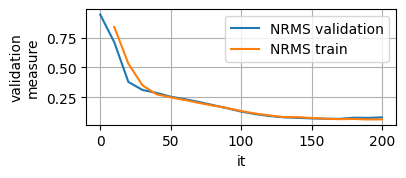

In [21]:
import numpy as np
plt.figure(figsize=(4,1.5))
plt.plot(train_dict['it_counter'], train_dict['NRMS_val'])
plt.plot(train_dict['it_counter'], train_dict['NRMS_train'])
plt.legend(['NRMS validation', 'NRMS train'])
plt.grid(); plt.xlabel('it'); plt.ylabel('validation\nmeasure')
plt.show()

## 9. Restarting training

If you want to restart training with the same optimizer you can use:

In [22]:
import torch
model = train_dict['last_model']

optimizer = torch.optim.Adam(model.parameters()) #or the optimizer that you selected
optimizer.load_state_dict(train_dict['last_optimizer_state'])

train_dict = dsi.fit(model, train, val, n_its=201, val_freq=10, optimizer=optimizer)


Number of samples to train on = 61739


  0%|          | 0/201 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.06717!! nan samps/sec
it      10 NRMS loss 0.06928 NRMS val 0.10416   6719.25 samps/sec
it      20 NRMS loss 0.08278 NRMS val 0.09314   6808.57 samps/sec
it      30 NRMS loss 0.07425 NRMS val 0.06692!! 6796.49 samps/sec
it      40 NRMS loss 0.06091 NRMS val 0.05533!! 6365.85 samps/sec
it      50 NRMS loss 0.06163 NRMS val 0.08280   6495.54 samps/sec
it      60 NRMS loss 0.06084 NRMS val 0.05746   6556.87 samps/sec
it      70 NRMS loss 0.05917 NRMS val 0.05523!! 6604.02 samps/sec
it      80 NRMS loss 0.05511 NRMS val 0.06172   6650.44 samps/sec
it      90 NRMS loss 0.05593 NRMS val 0.05128!! 6673.43 samps/sec
it     100 NRMS loss 0.06536 NRMS val 0.11851   6704.21 samps/sec
it     110 NRMS loss 0.06302 NRMS val 0.05014!! 6724.78 samps/sec
it     120 NRMS loss 0.05203 NRMS val 0.05096   6746.47 samps/sec
it     130 NRMS loss 0.04926 NRMS val 0.05559   6760.80 samps/sec
it     140 NRMS loss 0.05323 NRMS val 0.06890   6769.30 samps/sec
it     150 NRMS lo

## 10. Saving and loading models



Saving and loading model can be done in multiple ways. The first and most straightforward way is to use `cloudpickle`.

In [23]:
import deepSI as dsi
model = dsi.SUBNET(nu='scalar', ny='scalar', norm=dsi.Norm(0,1,0,1), nx=2, na=4, nb=4)

import cloudpickle
cloudpickle.dump(model, open('model.pth','wb'))
model = cloudpickle.load(open('model.pth','rb'))

Another good option is `safetensors` with state dicts. This makes it much safer to share since safetensors files cannot execute arbitrary code unlike cloupickle, reducing risks associated with loading untrusted models.

In [24]:
try:
    from safetensors.torch import save_file
except ModuleNotFoundError:
    print("safetensors not installed, skipping cell")
else:
    import deepSI as dsi
    model = dsi.SUBNET(nu='scalar', ny='scalar', norm=dsi.Norm(0,1,0,1), nx=2, na=4, nb=4)
    save_file(model.state_dict(), "model_state-1.safetensors")
    del model
    
    from safetensors.torch import load_file
    model = dsi.SUBNET(nu='scalar', ny='scalar', norm=dsi.Norm(0,1,0,1), nx=2, na=4, nb=4) #recreate the model structure
    state = load_file("model_state-1.safetensors")
    model.load_state_dict(state) #load the parameters

safetensors not installed, skipping cell


### 10.1 Recovering from a crash

After a crash (e.g. a forced windows update) you can recover the training progress with the following steps:

In [25]:
import deepSI as dsi
from nonlinear_benchmarks import Cascaded_Tanks
import torch
train, test = Cascaded_Tanks()
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train)
train, val = train[:-700], train[-700:]
torch.random.manual_seed(0)
model = dsi.SUBNET(nu, ny, norm, nx=2, na=4, nb=4)
train_dict = dsi.fit(model, train, val, n_its=100, val_freq=25)
del train_dict, model # Oops I deleted the results, time to recover them from the checkpoint

Number of samples to train on = 271


  0%|          | 0/100 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.97981!! nan samps/sec
it      25 NRMS loss 1.03293 NRMS val 1.32194   6870.23 samps/sec
it      50 NRMS loss 0.87532 NRMS val 0.80628!! 6852.13 samps/sec
it      75 NRMS loss 0.70106 NRMS val 0.60638!! 6850.91 samps/sec
it     100 NRMS loss 0.44274 NRMS val 2.05038   6847.93 samps/sec


In [26]:
import os, cloudpickle
folder = dsi.fitting.get_checkpoint_dir()
print('Training results saving directory:', folder) #you can manually go here

# get the most resent file with :
most_recent_file = max((os.path.join(folder, f) for f in os.listdir(folder)), key=os.path.getmtime)
train_dict = cloudpickle.load(open(most_recent_file,'rb'))
# train_dict.keys() contains all the info 
model = train_dict['best_model']

Training results saving directory: C:\Users\gerben\AppData\Local\deepSI-checkpoints/


## 11. n-step errors

One of the best ways to analyise and develop models is in my opinion to analyse the n-step-error.

n-step-error is very simple; it is the (normalized) expected error after taking 
 steps forward in time after state initialization. (see: https://arxiv.org/abs/2012.07697 for details or docs for details)

In [27]:
import deepSI as dsi
import nonlinear_benchmarks as nlb
from matplotlib import pyplot as plt

train_val, test = nlb.Silverbox()
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train_val)
train_val, test = norm.transform(train_val), norm.transform(test) #normalize data
s = int(len(train_val)*0.95)
train, val = train_val[:s], train_val[s:]
model = dsi.models.SUBNET(nu, ny, dsi.Norm(0, 1, 0, 1), nx=4)
train_dict = dsi.fit(model, train, val, n_its=1001, val_freq=100)


Number of samples to train on = 61739


  0%|          | 0/1001 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.92862!! nan samps/sec
it     100 NRMS loss 0.45504 NRMS val 0.19720!! 6115.92 samps/sec
it     200 NRMS loss 0.13398 NRMS val 0.10192!! 6478.72 samps/sec
it     300 NRMS loss 0.08147 NRMS val 0.08834!! 6615.01 samps/sec
it     400 NRMS loss 0.05968 NRMS val 0.06005!! 6611.59 samps/sec
it     500 NRMS loss 0.05644 NRMS val 0.07996   6664.74 samps/sec
it     600 NRMS loss 0.07515 NRMS val 0.10694   6694.42 samps/sec
it     700 NRMS loss 0.04553 NRMS val 0.04793!! 6486.69 samps/sec
it     800 NRMS loss 0.03738 NRMS val 0.05132   6495.77 samps/sec
it     900 NRMS loss 0.04360 NRMS val 0.04306!! 6490.63 samps/sec
it   1,000 NRMS loss 0.03887 NRMS val 0.04736   6468.51 samps/sec


In [28]:
(upast, ypast, ufuture, yfuture), ids = model.create_arrays(test, T=100, stride=10) #stride to not evaluate on all available datapoints and thus safe compute and memory.
import torch
with torch.no_grad():
    yfuture_pred = model(upast[ids], ypast[ids], ufuture[ids])

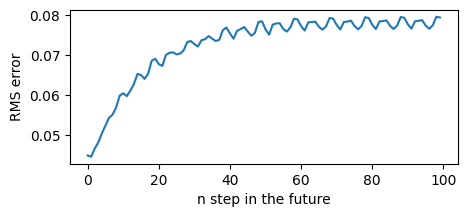

In [29]:
RMS_time = ((yfuture_pred - yfuture[ids])**2).mean(0)**0.5
plt.figure(figsize=(5,2))
plt.plot(RMS_time)
plt.xlabel('n step in the future')
plt.ylabel('RMS error')
plt.show()

Here you can see that the encoder predicts the initial state quite accurately and the performance degredes when increasing the number of steps that need to be predicted in the future. Generally you can use this graph also to pick $T$ since it should be somewhere where the n-step-error starts to plateau. 

## 12. Cuda

Depending on the model size, structure, and the degree of parallelism it is sometimes faster to run on a GPU instead of a CPU. Below an example is given with a small model where it is not faster to run using cuda.

In [33]:
import deepSI as dsi
import nonlinear_benchmarks as nlb
import torch
if torch.cuda.is_available():
    train_val, test = nlb.Silverbox()
    nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train_val)
    train_val, test = norm.transform(train_val), norm.transform(test) #normalize data
    s = int(len(train_val)*0.95)
    train, val = train_val[:s], train_val[s:]

    for device in ['cpu', 'cuda']:
        print(f'{device = }')
        torch.manual_seed(0)
        model = dsi.models.SUBNET(nu, ny, dsi.Norm(0, 1, 0, 1), nx=4)
        model.to(device) #you should move it before calling the fit
        optimizer = torch.optim.Adamax(model.parameters()) #create the optimizer after the .to call
        train_dict = dsi.fit(model, train, val, n_its=1001, val_freq=100, device=device, optimizer=optimizer)


device = 'cpu'
Number of samples to train on = 61739


  0%|          | 0/1001 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.99626!! nan samps/sec
it     100 NRMS loss 0.60581 NRMS val 0.27648!! 6492.02 samps/sec
it     200 NRMS loss 0.18159 NRMS val 0.15365!! 6403.86 samps/sec
it     300 NRMS loss 0.11793 NRMS val 0.12647!! 6325.17 samps/sec
it     400 NRMS loss 0.09611 NRMS val 0.09750!! 6392.34 samps/sec
it     500 NRMS loss 0.08544 NRMS val 0.09348!! 6376.74 samps/sec
it     600 NRMS loss 0.07418 NRMS val 0.09384   6433.99 samps/sec
it     700 NRMS loss 0.07000 NRMS val 0.08232!! 6433.79 samps/sec
it     800 NRMS loss 0.06342 NRMS val 0.05766!! 6462.30 samps/sec
it     900 NRMS loss 0.05231 NRMS val 0.05636!! 6484.89 samps/sec
it   1,000 NRMS loss 0.05433 NRMS val 0.05975   6492.68 samps/sec
device = 'cuda'
Number of samples to train on = 61739


  0%|          | 0/1001 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.99626!! nan samps/sec
it     100 NRMS loss 0.60581 NRMS val 0.27648!! 5068.56 samps/sec
it     200 NRMS loss 0.18159 NRMS val 0.15365!! 4975.40 samps/sec
it     300 NRMS loss 0.11793 NRMS val 0.12647!! 4999.81 samps/sec
it     400 NRMS loss 0.09611 NRMS val 0.09750!! 5023.89 samps/sec
it     500 NRMS loss 0.08544 NRMS val 0.09348!! 5049.34 samps/sec
it     600 NRMS loss 0.07418 NRMS val 0.09384   5041.56 samps/sec
it     700 NRMS loss 0.07000 NRMS val 0.08243!! 5041.09 samps/sec
it     800 NRMS loss 0.06336 NRMS val 0.05820!! 5021.37 samps/sec
it     900 NRMS loss 0.05244 NRMS val 0.05599!! 5015.86 samps/sec
it   1,000 NRMS loss 0.05469 NRMS val 0.05394!! 5012.38 samps/sec
